# Partial differential equations

Partial differential equations occur when we are dealing with functions of more than one variable, for instance *fields*.

Examples:

- Electrostatic potential $\phi (x,y,z)$ (Poisson's equation)
$$
\Delta\phi(x,y,z) = -\frac{\rho(x,y,z)}{\epsilon_0}
$$

- Density or temperature profiles (diffusion/heat equation)
$$
\frac{\partial u(\mathbf{x},t)}{\partial t} = D \Delta u(\mathbf{x},t)
$$

- Displacement (amplitude) profile (wave equation)
$$
\frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} = c^2\Delta u(\mathbf{x},t)
$$

- Fluid dynamical fields (flow velocity) -- e.g. Navier-Stokes equations 

## General methods for solving PDE's

- **Finite difference method**
    - Approximate the derivatives by finite differences
    - Easier to implement than other methods
    - Works best for regular (rectangular) shapes
- Finite element method
    - Subdivide the system into smaller parts -- finite elements
    - Boundary value problems in 2/3 dimensions
    - Works well for irregular shapes
- Finite volume method
    - Convert surface integrals around each mesh point into volume integrals
    - Conserves mass by design, good for fluid dynamical equations

## Boundary value problems

<img src="http://www-personal.umich.edu/~mejn/cp/figures/fig9-2.png" alt="Electrostatics problem" style="width: 400px;"/> 
<center>
    Source: M. Newman, Computational Physics
</center>

Boundary value problems typically deal with static solutions (no time variable)

Consider Laplace's equation (no external charges) in two dimensions
$$
\frac{\partial^2 \phi(x,y)}{\partial x^2}
+
\frac{\partial^2 \phi(x,y)}{\partial y^2}
=
0.
$$



Boundary conditions: one of the walls has voltage $V$ applied to it, the rest are grounded:
\begin{align*}
\phi(x,L) & = V, \\
\phi(x,0) & = 0, \\
\phi(0,y) & = 0, \\
\phi(L,y) & = 0.
\end{align*}

Let us apply finite difference method. 
Discretize the box into a grid in steps $a = L / M$ in each direction.
Approximate the derivatives by central differences:
\begin{align*}
\frac{\partial^2 \phi(x,y)}{\partial x^2} & = \frac{\phi(x+a,y) - 2\phi(x,y) + \phi(x-a,y)}{a^2}, \\
\frac{\partial^2 \phi(x,y)}{\partial y^2} & = \frac{\phi(x,y+a) - 2\phi(x,y) + \phi(x,y-a)}{a^2}.
\end{align*}

The Laplace's equation becomes
$$
\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) - 4 \phi(x,y) = 0.
$$

In principle, this is a system of $N \sim M^2$ linear equations that can be solved exactly.
The general method will however require $O(N^3) = O(M^6)$ operations which becomes unfeasible already for $M \sim 100$ or so.

## Jacobi (relaxation) method

Start with some initial guess $\phi_0(x,y)$. The next iteration is given by
$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4}
$$
for all points inside the box. Preserve the boundary conditions at each iteration:
\begin{align*}
\phi_{n+1}(x,L) & = V, \\
\phi_{n+1}(x,0) & = 0, \\
\phi_{n+1}(0,y) & = 0, \\
\phi_{n+1}(L,y) & = 0.
\end{align*}

This is the Jacobi (or relaxation) method, and for Laplace's equation it is always converges.

In [16]:
import numpy as np

# Single iteration of the Jacobi method
# The new field is written into phinew
def iteration_jacobi(phinew, phi):
    M = len(phi) - 1
    
    # Boundary conditions
    phinew[0,:] = phi[0,:]
    phinew[M,:] = phi[M,:]
    phinew[:,0] = phi[:,0]
    phinew[:,M] = phi[:,M]
    
    for i in range(1,M):
        for j in range(1,M):
            phinew[i,j] = (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4
                
    delta = np.max(abs(phi-phinew))
    
    return delta

def jacobi_solve(phi0, target_accuracy = 1e-6, max_iterations = 100):
    delta = target_accuracy + 1.
    phi = phi0.copy()
    for i in range(max_iterations):
        delta = iteration_jacobi(phi, phi0)
        phi0, phi = phi, phi0
        
        if (delta <= target_accuracy):
            print("Jacobi method converged in " + str(i+1) + " iterations")
            return phi0
        
    print("Jacobi method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    print("The error estimate is ", delta)
        
    return phi

Jacobi method converged in 1909 iterations


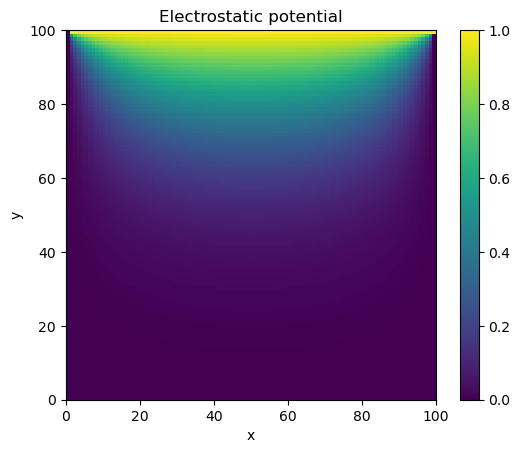

In [15]:
# Constants
M = 100         # Grid squares on a side
V = 1.0         # Voltage at top wall
target = 1e-4   # Target accuracy

# Initialize with zeros
phi = np.zeros([M+1,M+1],float)
# Boundary condition
phi[0,:] = V
phi[:,0] = 0

phi = jacobi_solve(phi, target, 10000)

# Plot
import matplotlib.pyplot as plt

plt.title("Electrostatic potential")
plt.xlabel("x")
plt.ylabel("y")
CS = plt.imshow(phi, vmax=1., vmin=0.,origin="upper",extent=[0,M,0,M])
plt.colorbar(CS)
plt.show()

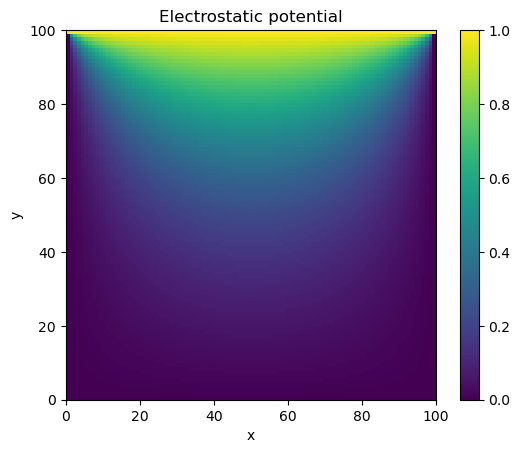

In [8]:
## This is adapted Example 9.1 from M. Newman, "Computational Physics"
## Source: http://www-personal.umich.edu/~mejn/cp/programs/laplace.py

from numpy import empty,zeros,max
from pylab import imshow,gray,show

# Constants
M = 100         # Grid squares on a side
V = 1.0         # Voltage at top wall
target = 1e-5   # Target accuracy

# Create arrays to hold potential values
phi = zeros([M+1,M+1],float)
phi[0,:] = V
phiprime = empty([M+1,M+1],float)

# Main loop
delta = 1.0
while delta>target:

    # Calculate new values of the potential
    for i in range(M+1):
        for j in range(M+1):
            if i==0 or i==M or j==0 or j==M:
                phiprime[i,j] = phi[i,j]
            else:
                phiprime[i,j] = (phi[i+1,j] + phi[i-1,j] \
                                 + phi[i,j+1] + phi[i,j-1])/4

    # Calculate maximum difference from old values
    delta = max(abs(phi-phiprime))

    # Swap the two arrays around
    phi,phiprime = phiprime,phi

# Make a plot
# imshow(phi)
# gray()
# show()
plt.title("Electrostatic potential")
plt.xlabel("x")
plt.ylabel("y")
CS = plt.imshow(phi, vmax=1., vmin=0.,origin="upper",extent=[0,M,0,M])
plt.colorbar(CS)
plt.show()

## Gauss-Seidel method with overrelaxation

The base Jacobi method corresponds to an iteration
$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4}
$$

This requires to have two arrays independently.
In Gauss-Seidel method one uses the already computed values of $\phi_{n+1}$ where availabl instead.
The method thus corresponds to
$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_{n+1}(x-a,y) + \phi_n(x,y+a) + \phi_{n+1}(x,y-a)}{4}
$$

Another modification is the use of overrelaxation.

The base Jacobi method is a type of relaxation method
$$
\phi_{n+1}(x,y) = \phi_n(x,y) + \Delta_n \phi(x,y).
$$

A way to speed-up calculation is to overrelaxate the solution a bit
$$
\phi_{n+1}(x,y) = \phi_n(x,y) + (1+\omega) \Delta_n \phi(x,y),
$$
where $\omega > 0$.

This implies the following iterative procedure
$$
\phi_{n+1}(x,y) = (1+\omega) \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4} - \omega \, \phi_n(x,y).
$$

This is unstable for $\omega > 0$. However, applied to Gauss-Seidel method, this corresponds to
$$
\phi_{n+1}(x,y) = (1+\omega) \frac{\phi_n(x+a,y) + \phi_{n+1}(x-a,y) + \phi_n(x,y+a) + \phi_{n+1}(x,y-a)}{4} - \omega \, \phi_n(x,y),
$$
and provides generally stable solution for $\omega < 1$. 

In [40]:
import numpy as np

# Single iteration of the Jacobi method
# The new field is written into phinew
# omega >= 0 is the overelaxation parameter
def gaussseidel_iteration(phi, omega = 0):
    M = len(phi) - 1
    
    delta = 0.
    
    # New iteration
    for i in range(1,M):
        for j in range(1,M):
            phiold = phi[i,j]
            phi[i,j] = (1. + omega) * (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4 - omega * phi[i,j]
            delta = np.maximum(delta, abs(phiold - phi[i,j]))
    
    return delta

def gaussseidel_solve(phi0, omega = 0, target_accuracy = 1e-6, max_iterations = 100):
    delta = target_accuracy + 1.
    phi = phi0.copy()
    for i in range(max_iterations):
        delta = gaussseidel_iteration(phi, omega)
        
        if (delta <= target_accuracy):
            print("Jacobi method converged in " + str(i+1) + " iterations")
            return phi
        
    print("Jacobi method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    print("The error estimate is ", delta)
        
    return phi

Jacobi method converged in 202 iterations


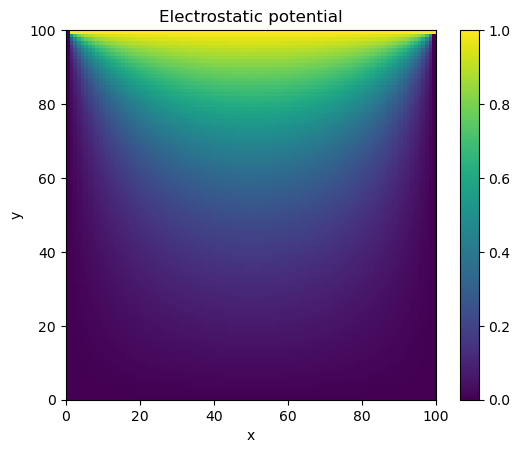

In [42]:
# Constants
M = 100         # Grid squares on a side
V = 1.0         # Voltage at top wall
target = 1e-4   # Target accuracy

# Initialize with zeros
phi = np.zeros([M+1,M+1],float)
# Boundary condition
phi[0,:] = V
phi[:,0] = 0

omega = 0.9
phi = gaussseidel_solve(phi, omega, target, 1000)

# Plot
import matplotlib.pyplot as plt

plt.title("Electrostatic potential")
plt.xlabel("x")
plt.ylabel("y")
CS = plt.imshow(phi, vmax=1., vmin=0.,origin="upper",extent=[0,M,0,M])
plt.colorbar(CS)
plt.show()